In [ ]:
!pip install pytorch-lightning

In [ ]:
!pip install pytesseract

In [ ]:
!pip install optuna

In [ ]:
import cv2
import numpy as np
import pytesseract
import matplotlib.pyplot as plt
import pandas as pd
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch

import torch
import random
from transformers import ViTFeatureExtractor, ViTModel
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import itertools
import optuna
import json
from pytorch_lightning.callbacks import EarlyStopping
from sklearn.decomposition import PCA

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


#1. Multimodal Time Series Model using Transformer and GRU

In [ ]:
import os
os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"
import torch
torch.use_deterministic_algorithms(False)

import json
import pandas as pd
import numpy as np

from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import ModelCheckpoint
from torch.nn import TransformerEncoder, TransformerEncoderLayer
import optuna

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

csv_file_path = "/content/drive/MyDrive/dip_project/ice_extent_full_dataset.csv" #path for the dataset with extracted features
df = pd.read_csv(csv_file_path)
df = df.sort_values(["Year", "Image"])

# year ranges
train_years = (1980, 2014)
val_years   = (2015, 2019)
test_years  = (2020, 2024)

# Split by year
train_df = df[df["Year"].between(*train_years)]
val_df   = df[df["Year"].between(*val_years)]
test_df  = df[df["Year"].between(*test_years)]

numerical_features = ["Ice Coverage (%)", "Retreat Area (Since 1979) (%)"]
vit_features       = [f"ViT_Feature_{i}" for i in range(768)]
target_column      = ["Retreat Area (Yearly) (%)"]

# Sequence creation
sequence_length = 3

def create_sequences(df, sequence_length, num_feats, vit_feats, tgt_col):
    seq_num, seq_vit, tgt, yrs = [], [], [], []
    for i in range(len(df) - sequence_length + 1):
        seq_num.append(df.iloc[i:i+sequence_length][num_feats].values)
        seq_vit.append(df.iloc[i:i+sequence_length][vit_feats].values)
        tgt.append(df.iloc[i+sequence_length-1][tgt_col].values)
        yrs.append(df.iloc[i+sequence_length-1]["Year"])
    return (np.array(seq_num),
            np.array(seq_vit),
            np.array(tgt).flatten(),
            np.array(yrs))

seq_num_train, seq_vit_train, y_train, years_train = create_sequences(
    train_df, sequence_length, numerical_features, vit_features, target_column
)
seq_num_val, seq_vit_val, y_val, years_val       = create_sequences(
    val_df, sequence_length, numerical_features, vit_features, target_column
)
seq_num_test, seq_vit_test, y_test, years_test    = create_sequences(
    test_df, sequence_length, numerical_features, vit_features, target_column
)

# Normalize Features & Targets

scaler_num    = StandardScaler()
scaler_target = StandardScaler()

flat_train_num = seq_num_train.reshape(-1, len(numerical_features))
scaler_num.fit(flat_train_num)
train_num = scaler_num.transform(flat_train_num).reshape(seq_num_train.shape)
val_num   = scaler_num.transform(seq_num_val.reshape(-1, len(numerical_features))).reshape(seq_num_val.shape)
test_num  = scaler_num.transform(seq_num_test.reshape(-1, len(numerical_features))).reshape(seq_num_test.shape)

y_train = scaler_target.fit_transform(y_train.reshape(-1,1)).flatten()
y_val   = scaler_target.transform(y_val.reshape(-1,1)).flatten()
y_test  = scaler_target.transform(y_test.reshape(-1,1)).flatten()

# PyTorch Tensors & DataLoaders

X_train_num = torch.tensor(train_num, dtype=torch.float32)
X_train_vit = torch.tensor(seq_vit_train, dtype=torch.float32)
y_train_t   = torch.tensor(y_train, dtype=torch.float32)

X_val_num   = torch.tensor(val_num, dtype=torch.float32)
X_val_vit   = torch.tensor(seq_vit_val, dtype=torch.float32)
y_val_t     = torch.tensor(y_val, dtype=torch.float32)

X_test_num  = torch.tensor(test_num, dtype=torch.float32)
X_test_vit  = torch.tensor(seq_vit_test, dtype=torch.float32)
y_test_t    = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_num, X_train_vit, y_train_t)
val_dataset   = TensorDataset(X_val_num,   X_val_vit,   y_val_t)
test_dataset  = TensorDataset(X_test_num,  X_test_vit,  y_test_t)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True,  num_workers=2)
val_loader   = DataLoader(val_dataset,   batch_size=32, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False, num_workers=2)

print(f"Train: {train_years} → {len(train_dataset)} sequences")
print(f"Val:   {val_years} → {len(val_dataset)} sequences")
print(f"Test:  {test_years} → {len(test_dataset)} sequences")

# Multimodal Transformer+GRU Model

class CombinedTransformerGRUModel(pl.LightningModule):
    def __init__(
        self,
        num_feature_dim,
        sequence_length: int = 3,
        d_model: int = 128,
        fusion_output_dim: int = 256,
        transformer_layers: int = 3,
        gru_hidden_size: int = 128,
        gru_layers: int = 1,
        dropout: float = 0.1,
        learning_rate: float = 1e-4,
    ):
        super().__init__()
        self.save_hyperparameters()

        self.encoder_num = nn.Linear(num_feature_dim, d_model)
        self.encoder_vit = nn.Linear(768, d_model)
        self.fusion_layer = nn.Linear(2 * d_model, fusion_output_dim)


        self.pos_emb = nn.Parameter(torch.zeros(1, sequence_length, fusion_output_dim))
        nn.init.trunc_normal_(self.pos_emb, std=0.02)

        # transformer & GRU
        encoder_layer = TransformerEncoderLayer(
            d_model=fusion_output_dim,
            nhead=8,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = TransformerEncoder(encoder_layer, num_layers=transformer_layers)

        self.gru = nn.GRU(
            input_size=fusion_output_dim,
            hidden_size=gru_hidden_size,
            num_layers=gru_layers,
            batch_first=True,
            dropout=dropout if gru_layers > 1 else 0
        )
        self.output_layer = nn.Linear(gru_hidden_size, 1)
        self.criterion = nn.MSELoss()
        self.learning_rate = learning_rate

    def forward(self, x_num, x_vit):
        # encode
        xn = self.encoder_num(x_num)
        xv = self.encoder_vit(x_vit)

        fused = self.fusion_layer(torch.cat([xn, xv], dim=2))

        fused = fused + self.pos_emb

        # transformer → GRU
        trans, _ = self.transformer(fused), None
        _, h_n = self.gru(trans)
        return self.output_layer(h_n[-1]).squeeze()


    def training_step(self, batch, batch_idx):
        x_num, x_vit, y = batch
        y_hat = self(x_num, x_vit)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x_num, x_vit, y = batch
        y_hat = self(x_num, x_vit)
        loss = self.criterion(y_hat, y)
        self.log("val_loss", loss, prog_bar=True, on_epoch=True)
        return loss

    def configure_optimizers(self):
        opt = torch.optim.AdamW(self.parameters(), lr=self.learning_rate)
        sched = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode="min", patience=3, factor=0.5)
        return {"optimizer": opt, "lr_scheduler": sched, "monitor": "val_loss"}


# Hyperparameter Tuning with Optuna

def objective(trial):
    params = {
        "d_model": trial.suggest_categorical("d_model", [64,128,256]),
        "fusion_output_dim": trial.suggest_categorical("fusion_output_dim", [128,256,512]),
        "gru_hidden_size": trial.suggest_categorical("gru_hidden_size", [64,128]),
        "dropout": trial.suggest_float("dropout", 0.1, 0.5),
        "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-3),
        "transformer_layers": trial.suggest_int("transformer_layers", 1, 6),
    }
    model = CombinedTransformerGRUModel(
        num_feature_dim=len(numerical_features),
        **params
    )
    logger = CSVLogger(save_dir="logs", name=f"trial_{trial.number}")
    ckpt  = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)
    trainer = pl.Trainer(
        max_epochs=50, logger=logger, callbacks=[ckpt],
        accelerator="gpu" if torch.cuda.is_available() else "cpu",
        devices=1, enable_progress_bar=False
    )
    trainer.fit(model, train_dataloaders=train_loader, val_dataloaders=val_loader)
    return ckpt.best_model_score.item() if ckpt.best_model_score is not None else float("inf")

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=20)
best_params = study.best_params
with open("/content/drive/MyDrive/dip_project/multimodal/best_params.json", "w") as f:
    json.dump(best_params, f)


# Final Model Training & Evaluation

best = json.load(open("/content/drive/MyDrive/dip_project/multimodal/best_params.json"))
final_model = CombinedTransformerGRUModel(
    num_feature_dim=len(numerical_features),
    **best
).to(device)

logger_final = CSVLogger(save_dir="/content/drive/MyDrive/dip_project/log", name="final_model")
ckpt_final  = ModelCheckpoint(monitor="val_loss", mode="min", save_top_k=1)
trainer = pl.Trainer(
    max_epochs=50, logger=logger_final, callbacks=[ckpt_final],
    accelerator="gpu" if torch.cuda.is_available() else "cpu", devices=1
)
trainer.fit(final_model, train_dataloaders=train_loader, val_dataloaders=val_loader)

def evaluate_model(model, loader, device="cpu"):
    model.to(device)
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x_num, x_vit, y in loader:
            x_num, x_vit = x_num.to(device), x_vit.to(device)
            y_hat = model(x_num, x_vit).cpu().numpy()
            y_true.extend(y.numpy())
            y_pred.extend(y_hat)
    return np.array(y_true), np.array(y_pred)

device = "cuda" if torch.cuda.is_available() else "cpu"
y_t, y_p = evaluate_model(final_model, test_loader, device)

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
print("\n** Model Evaluation **")
print(f"MAE: {mean_absolute_error(y_t,y_p):.4f}, MSE: {mean_squared_error(y_t,y_p):.4f}, RMSE: {np.sqrt(mean_squared_error(y_t,y_p)):.4f}, R²: {r2_score(y_t,y_p):.4f}")

def predict_and_save_test_results(model, loader, scaler, years, path):
    y_true, y_pred = evaluate_model(model, loader, device)
    y_true_orig = scaler.inverse_transform(y_true.reshape(-1,1)).flatten()
    y_pred_orig = scaler.inverse_transform(y_pred.reshape(-1,1)).flatten()
    df_out = pd.DataFrame({
        "Year": years,
        "Actual Retreat Area (Yearly) (%)": y_true_orig,
        "Predicted Retreat Area (Yearly) (%)": y_pred_orig
    })
    df_out.groupby("Year", as_index=False).mean().to_csv(path, index=False)
    print("Saved to", path)
    return df_out

TEST_RESULTS_PATH = "/content/drive/MyDrive/dip_project/multimodal_final/multimodal_sea_ice_extent_predictions.csv"
results_df = predict_and_save_test_results(final_model, test_loader, scaler_target, years_test, TEST_RESULTS_PATH)


[I 2025-04-25 02:33:29,217] A new study created in memory with name: no-name-437dc1f2-fa39-4d8a-ab31-aff318bc7571
<ipython-input-14-2a63bae5d146>:209: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "learning_rate": trial.suggest_loguniform("learning_rate", 1e-4, 1e-3),
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type               | Params | Mode 
------------------------------------------------------------
0 | encoder_num  | Linear             | 768    | train
1 | encoder_vit  | Line

Train: (1980, 2014) → 990 sequences
Val:   (2015, 2019) → 158 sequences
Test:  (2020, 2024) → 158 sequences


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (31) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.
[I 2025-04-25 02:34:31,075] Trial 0 finished with value: 0.11724937707185745 and parameters: {'d_model': 256, 'fusion_output_dim': 256, 'gru_hidden_size': 128, 'dropout': 0.20444562078006012, 'learning_rate': 0.00014772184785608058, 'transformer_layers': 3}. Best is trial 0 with value: 0.11724937707185745.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.



** Model Evaluation **
MAE: 0.2767, MSE: 0.1458, RMSE: 0.3818, R²: 0.8951
Saved to /content/drive/MyDrive/dip_project/multimodal_final/multimodal_sea_ice_extent_predictions.csv


#2. Epoch vs Validation Loss

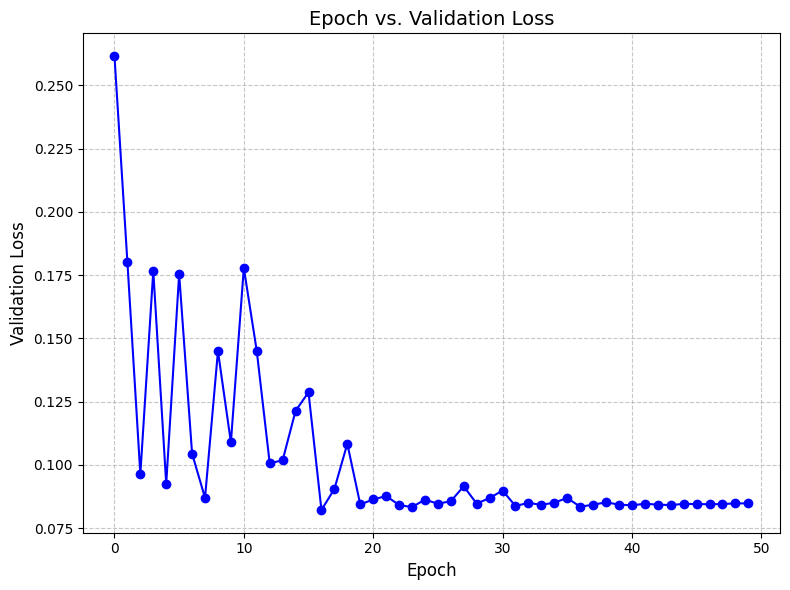

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = r"/content/drive/MyDrive/dip_project/log/final_model/version_2/metrics.csv" #file path derived from log during testing
df = pd.read_csv(csv_path)

df_val = df.dropna(subset=["val_loss"])

epoch_loss = df_val.groupby("epoch")["val_loss"].last().reset_index()

plt.figure(figsize=(8, 6))
plt.plot(epoch_loss["epoch"], epoch_loss["val_loss"], marker='o', linestyle='-', color='blue')
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Validation Loss", fontsize=12)
plt.title("Epoch vs. Validation Loss", fontsize=14)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


#3. Comparison of Actual vs. Predicted Retreat Area Over Years

   Year  Actual Retreat Area (Yearly) (%)  Predicted Retreat Area (Yearly) (%)
0  2020                          5.027771                             5.168388
1  2021                          4.532993                             5.980154
2  2022                          5.311274                             5.881360
3  2023                          8.271158                             7.929914
4  2024                          5.683827                             5.592300


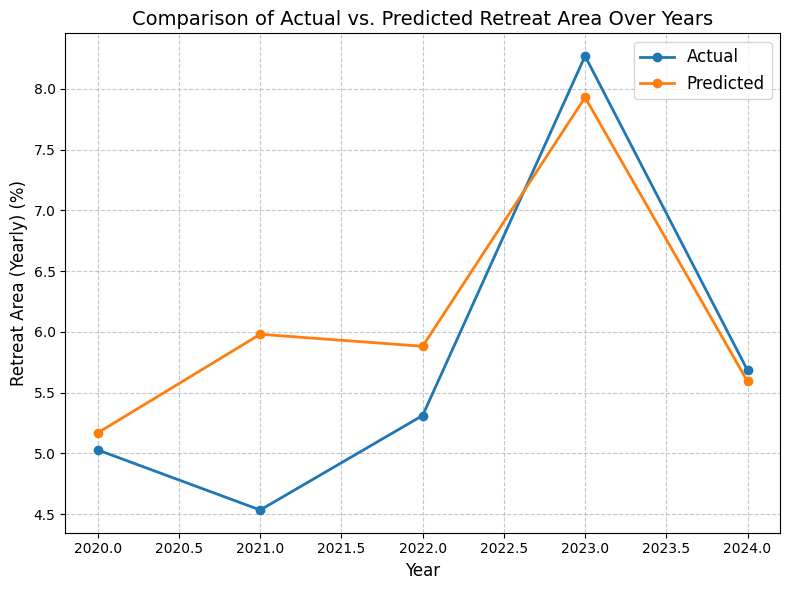

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

csv_path = r"/content/drive/MyDrive/dip_project/multimodal/multimodal_sea_ice_predictions.csv" #file path derived from log during testing
df = pd.read_csv(csv_path)

print(df)

plt.figure(figsize=(8, 6))

plt.plot(df["Year"], df["Actual Retreat Area (Yearly) (%)"], label="Actual", marker="o", linewidth=2)
plt.plot(df["Year"], df["Predicted Retreat Area (Yearly) (%)"], label="Predicted", marker="o", linewidth=2)

plt.xlabel("Year", fontsize=12)
plt.ylabel("Retreat Area (Yearly) (%)", fontsize=12)
plt.title("Comparison of Actual vs. Predicted Retreat Area Over Years", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


   Year  Actual Retreat Area (Yearly) (%)  Predicted Retreat Area (Yearly) (%)
0  2020                          5.027771                             5.168388
1  2021                          4.532993                             5.980154
2  2022                          5.311274                             5.881360
3  2023                          8.271158                             7.929914
4  2024                          5.683827                             5.592300


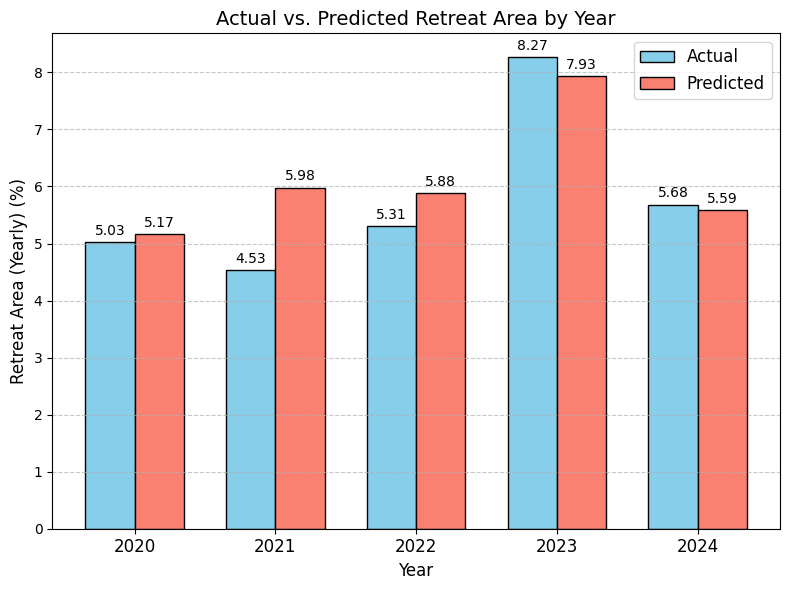

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

csv_path = r"/content/drive/MyDrive/dip_project/multimodal_final/multimodal_sea_ice_extent_predictions.csv" #file path derived from log during testing
df = pd.read_csv(csv_path)
print(df)

years = df["Year"].astype(int)
actual_values = df["Actual Retreat Area (Yearly) (%)"]
predicted_values = df["Predicted Retreat Area (Yearly) (%)"]

x = np.arange(len(years))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 6))

rects1 = ax.bar(x - width/2, actual_values, width, label='Actual', color='skyblue', edgecolor='black')

rects2 = ax.bar(x + width/2, predicted_values, width, label='Predicted', color='salmon', edgecolor='black')

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Retreat Area (Yearly) (%)', fontsize=12)
ax.set_title('Actual vs. Predicted Retreat Area by Year', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(years, fontsize=12)
ax.legend(fontsize=12)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for rect in rects1 + rects2:
    height = rect.get_height()
    ax.annotate(f'{height:.2f}',
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),
                textcoords="offset points",
                ha='center', va='bottom')

plt.tight_layout()
plt.show()

